# **02 DATA CLEANING AND PREPROCESSING**

the objective of this notebook is to explore the data we have uploaded and to preprocess data before delving into our goal: predicting prices.





## Goal fo the project: predicting PRICE

Before delving into handling missing values and feature engineering, we need to first define our analytical objectives and determine our target variables. This clarity will guide our feature selection process, allowing us to retain only the relevant columns and eliminate unnecessary ones.

Our primary objective is to develop a pricing model for Airbnb listings.


## Importing the libraries and Data

First, we import the necessary libraries and load our data of interest—the listings extended dataset—for our analysis.
I chose to use Pathlib over Os, since Pathlib treats paths as objects, making it easier to chain methods compared to os.path.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import skew, kurtosis
import geopandas as gpd
from shapely.geometry import Point
import sys

# Project root & data paths
project_root = Path().resolve().parent
src_path = project_root / "src"
sys.path.append(str(src_path))

from data.preprocessing import *
from data._02_feature_engineering import (
    categorize_reviews,
    convert_and_calculate_days,
    create_first_review_age_categories,
    create_last_review_recency_categories,
    convert_to_ordered_category,
    convert_columns_to_boolean,
)
from data._02b_dictionary_mapping import host_location_dict
from data._02c_dictionary_mapping import LOCATION_HIERARCHY
from data._02d_property_type_mapping import property_type_dict 
from data._03_represent_categorical_data import plot_categorical_distribution
from data._04_represent_numerical_data import plot_percentage_distribution


In [2]:
# Set up project paths
project_root = Path().resolve().parent


In [3]:
listings_extended_path = project_root / "data" / "raw" / "listings_extended.csv"

In [4]:


# Load the data
df_raw_listings_extended = pd.read_csv(listings_extended_path)
df_raw = df_raw_listings_extended.copy()  # Work on a copy to keep the original data intact


as a first thinkg, we check the structure and firs row to gather a general idea of our data.

In [5]:

print(f"The dataset contains {len(df_raw)} Airbnb listings")
pd.set_option('display.max_columns', len(df_raw.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
df_raw.head(3)

The dataset contains 23705 Airbnb listings


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6400,https://www.airbnb.com/rooms/6400,20240917031337,2024-09-17,city scrape,The Studio Milan,"Enjoy your stay at The Studio, a light-filled ...",The neighborhood is quiet and very well connec...,https://a0.muscache.com/pictures/474737/5955ba...,13822,https://www.airbnb.com/users/show/13822,Francesca,2009-04-17,"Milan, Italy","I'm am Francesca Sottilaro, i live in Milan an...",NaN,NaN,0%,f,https://a0.muscache.com/im/users/13822/profile...,https://a0.muscache.com/im/users/13822/profile...,Zona 5,1,2,"['email', 'phone']",t,f,"Milan, Lombardy, Italy",TIBALDI,NaN,45.44119,9.17813,Private room in rental unit,Private room,1,3.5,3.5 baths,3.0,1.0,"[""First aid kit"", ""Hangers"", ""Wifi"", ""Elevator...",$100.00,4,5,4,4,5,5,4.0,5.0,NaN,t,23,53,83,358,2024-09-17,10,0,0,2010-04-19,2019-04-13,4.89,5.00,5.00,5.00,5.00,4.56,4.67,NaN,f,1,0,1,0,0.06
1,23986,https://www.airbnb.com/rooms/23986,20240917031337,2024-09-17,city scrape,""" Characteristic Milanese flat""",I look forward to welcoming you in my flat; it...,NaN,https://a0.muscache.com/pictures/623d63f8-56cf...,95941,https://www.airbnb.com/users/show/95941,Jeremy,2010-03-19,"Milan, Italy","Hallo , I'm Jeremy Hayne I live in Milan and I...",within an hour,100%,20%,f,https://a0.muscache.com/im/users/95941/profile...,https://a0.muscache.com/im/users/95941/profile...,Navigli,1,1,['email'],t,t,NaN,NAVIGLI,NaN,45.44806,9.17373,Entire rental unit,Entire home/apt,4,1.0,1 bath,1.0,1.0,"[""Hot water"", ""Hangers"", ""Fast wifi \u2013 92 ...",$180.00,1,730,1,1,730,730,1.0,730.0,NaN,t,28,57,87,362,2024-09-17,27,1,0,2012-04-24,2024-04-20,4.65,4.67,4.22,4.59,4.74,4.70,4.48,NaN,f,1,1,0,0,0.18
2,40470,https://www.airbnb.com/rooms/40470,20240917031337,2024-09-17,city scrape,Giacinto Cosy & clean flat near MM1,NaN,NaN,https://a0.muscache.com/pictures/891684/01c17b...,174203,https://www.airbnb.com/users/show/174203,Giacinto,2010-07-20,"Milan, Italy","Ciao sono Giacinto, amo i viaggi fatti con la ...",within an hour,100%,38%,f,https://a0.muscache.com/im/users/174203/profil...,https://a0.muscache.com/im/users/174203/profil...,Zona 2,2,2,"['email', 'phone']",t,t,NaN,VIALE MONZA,NaN,45.52023,9.22747,Entire rental unit,Entire home/apt,4,1.0,1 bath,2.0,4.0,"[""First aid kit"", ""Hot water"", ""Air conditioni...",$80.00,3,90,3,3,90,90,3.0,90.0,NaN,t,21,21,21,183,2024-09-17,43,2,0,2010-12-20,2024-08-17,4.66,4.71,4.83,4.98,4.88,4.44,4.51,NaN,f,2,2,0,0,0.26


## Dropping Columns

To decide which columns to drop, we should look back at our goal, which is to build a robust revenue prediction model for Airbnb listings. This is determined by the price and occupancy_rate. Therefore, to decide which features to keep, we should examine and retain only the ones that demonstrate predictive power for either of these components.



### Feature Selection Rationale

In this initial step, I will remove columns that are not relevant to our goal. Decisions here based on the column descriptions provided in the data dictionary from [Inside Airbnb](https://insideairbnb.com/get-the-data/) and documented in the following section.

### Features to Exclude

1. **Metadata and Collection Details**
   - `scrape_id` - Internal ID for the data collection batch this listing was part of
   - `source` - How this listing was found: "neighbourhood search" = Found by searching the city; "previous scrape" = Seen in a recent scrape (within 65 days) and confirmed still active
   - `calendar_last_scrapd` - Date and time when this listing's data was last collected (in UTC)
   - `instant_bookable` - Whether guests can book immediately without host approval (t=yes, f=no)

2. **Media and URLs**
   - `picture_url`
   - `host_url`
   - `host_thumbnail_url`
   - `host_picture_url`
   - Rationale: These URLs don't provide predictive value in our numerical modeling approach


3. **Administrative Fields**
   - `license` - Official permit, license, or registration number (if required by local laws)
   - `host_verifications` - Whether Airbnb has verified the host's identity (t=yes, f=no)

4. **Textual or other Data we are not interested in right now**
   - `bathrooms_text` - is redundant to 'baths'. It is just the textual correspondance of baths, which is a float.
   - `name` - the name given to the AirBnB
   - `host_name` - Host's name (usually first name only). Rationale: it could be interesting verifying whether there is a difference between "professional" hosts and non-professional hosts.
   we will keep `host_id`

5. **Booking Rules**

   Hosts can define different booking rules for different dates (e.g., holidays, weekends, off-season). Airbnb provides several features that reflect both default and dynamic booking settings. To avoid redundancy, I chose to keep only the following two features:

   - `minimum_nights_avg_ntm` - Average minimum nights required across all days in the next 365 days
   - `maximum_nights_avg_ntm`- Average maximum nights allowed across all days in the next 365 days

   These offer a calendar-aware average of the booking rules, making them more representative of actual availability across the year.

   **Features removed:**
   
   Hosts can set different booking rules for different dates. The basic `minimum_nights` and `maximum_nights` are just the default rules, but hosts often change these for Weekends Holidays, Peak season or Off-season

   Basic Booking Rules:
   - `minimum_nights` - The default minimum number of nights guests must book
   - `maximum_nights` - The default maximum number of nights guests can book
   
   Advanced Calendar Rules (calculated)
   Hosts can set different rules for different dates (holidays, peak seasons, etc.). These fields analyze the entire calendar:
   - `minimum_minimum_nights` - The shortest minimum stay found anywhere in the next 365 days
   - `maximum_minimum_nights` - The longest minimum stay found anywhere in the next 365 days.
   - `minimum_maximum_nights` - The shortest maximum stay found anywhere in the next 365 days
   - `maximum_maximum_nights` - The longest maximum stay found anywhere in the next 365 days
   
   While informative, these features are highly correlated with the average value, and we want to reduce redundancy and limit dimensionality, helping to avoid the curse of dimensionality.

6. **Host Statistics**

   **Features removed:**

   - `calculated_host_listings_count_entire_homes`: Number of "entire home" listings this host has locally
   - `calculated_host_listings_count_private_rooms`: Number of "private room" listings this host has locally
   - `calculated_host_listings_count_shared_rooms`: Number of "shared room" listings this host has locally

   **Feature kept**
   - `host_listings_count`: Number of listings this host has in the current city/region


   




## Dropping columns
Based on our analysis before, we will proceed by just dropping the not necessary columns for our own analysis.

In [6]:
columns_to_drop = [
    "name",
    "host_name",
    "scrape_id",
    "source",
    "calendar_last_scraped",
    "picture_url",
    "host_url",
    "host_thumbnail_url",
    "host_picture_url",
    "license",
    "host_verifications",
    "instant_bookable",
    "minimum_nights",
    "maximum_nights",
    "minimum_minimum_nights",
    "maximum_minimum_nights",
    "minimum_maximum_nights",
    "maximum_maximum_nights",
    "bathrooms_text",
    "calculated_host_listings_count_entire_homes",
    "calculated_host_listings_count_private_room",
    "calculated_host_listings_count_shared_rooms",
    "has_availability",
    "num_missing_reviews",
    
]


df_raw_columns_dropped = df_raw.drop(columns=columns_to_drop, errors="ignore")



### Object Columns Analysis

We now identify and list categorical (object) columns to understand which features require categorical encoding and may need special handling during feature engineering. This step is crucial for determining appropriate preprocessing strategies for non-numeric data."""

In [7]:
"""def analyze_data_types(df):
    Analyze numerical and categorical columns in the DataFrame.
    # Get columns by type
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = df.select_dtypes(include=['object']).columns
    
    # Print summary 
    print("Dataset Overview:")
    print(f"Total columns: {len(df.columns)}")
    print(f"Numerical columns: {len(num_cols)}")
    print(f"Categorical columns: {len(cat_cols)}\n")
    
    print("Numerical Columns:")
    for col in num_cols:
        print(f"{col}: {df[col].dtype}")
    
    print("\nCategorical Columns:")
    for col in cat_cols:
        print(f"{col}: {df[col].dtype}")
    
# Run analysis
analyze_data_types(df_cleaned)
"""

'def analyze_data_types(df):\n    Analyze numerical and categorical columns in the DataFrame.\n    # Get columns by type\n    num_cols = df.select_dtypes(include=[\'int64\', \'float64\']).columns\n    cat_cols = df.select_dtypes(include=[\'object\']).columns\n    \n    # Print summary \n    print("Dataset Overview:")\n    print(f"Total columns: {len(df.columns)}")\n    print(f"Numerical columns: {len(num_cols)}")\n    print(f"Categorical columns: {len(cat_cols)}\n")\n    \n    print("Numerical Columns:")\n    for col in num_cols:\n        print(f"{col}: {df[col].dtype}")\n    \n    print("\nCategorical Columns:")\n    for col in cat_cols:\n        print(f"{col}: {df[col].dtype}")\n    \n# Run analysis\nanalyze_data_types(df_cleaned)\n'

# Missing Values Analysis

After dropping columns irrelevant for predicting the price or occupancy features, we can move onto missing value analysis. Understanding the reason behind missing values is crucial to determine the appropriate strategy to handle them, whether through imputation, removal, or by treating the absence itself as informative.

The first step is detecting which columsn are missing values and their extent.


### Columns with Missing Values and Their Percentages

In [8]:
missing_values = df_raw_columns_dropped.isnull().sum().sort_values(ascending=False)  
missing_percentage = (missing_values / len(df_raw_columns_dropped)) * 100 
missing_df = pd.DataFrame({"Missing Values": missing_values, "Percentage": missing_percentage})
missing_df[missing_df["Missing Values"] > 0]

,Missing Values,Percentage
neighbourhood_group_cleansed,23705,100.000000
calendar_updated,23705,100.000000
host_neighbourhood,14966,63.134360
neighborhood_overview,11377,47.994094
neighbourhood,11377,47.994094
host_about,11271,47.546931
host_location,4454,18.789285
review_scores_value,3981,16.793925
review_scores_location,3980,16.789707
review_scores_communication,3979,16.785488


Below is a breakdown of missing values by feature, along with their definitions from the **Airbnb Inside Data Dictionary**.

### Features with 100% Missing Values
| Feature | Missing % | Description | Strategy |
|---------|----------|------------|------------|
| **neighbourhood_group_cleansed** | 100.00% | The neighbourhood group as geocoded using the latitude and longitude against neighborhoods as defined by open or public digital shapefiles | Drop
| **calendar_updated** | 100.00% | No description provided, expected to be a date | Drop

### Features with 45-65% Missing Values
| Feature | Missing % | Description |  Strategy |
|---------|----------|------------|------------|
| **host_neighbourhood** | 63.13% | Neighborhood where the host is located | Drop
| **neighborhood_overview** | 47.99% | Host's description of the neighbourhood | present/absent
| **neighbourhood** | 47.99% | Neighborhood name as listed by the host | Drop
| **host_about** | 47.54% | Description about the host | present/absent

### Features with Moderate Missing Values (15-20%)
| Feature | Missing % | Description | Strategy |
|---------|----------|------------|------------|
| **host_location** | 18.78% | The host's self-reported location. | Mode Imputation
| **review_scores_value** | 16.79% | Rating for value/price. | category: 'no reviews'
| **review_scores_location** | 16.78% | Rating for location quality | category: 'no reviews'
| **review_scores_checkin** | 16.78% |  Rating for check-in process | category: 'no reviews'
| **review_scores_communication** | 16.78% | Rating for host communication. | category: 'no reviews'
| **review_scores_accuracy** | 16.78% | Rating for accuracy of listing description | category: 'no reviews'
| **review_scores_cleanliness** | 16.78% | Rating for cleanliness | category: 'no reviews'
| **first_review** | 16.78% | The date of the first/oldest review. | category: 'no reviews'
| **last_review** | 16.78% | The date of the last/newest review. | category: 'no reviews'
| **review_scores_rating** | 16.78% | Overall rating score. | category: 'no reviews'
| **reviews_per_month** | 16.78% | The average number of reviews per month the listing has over its lifetime. | number: '0'
| **host_response_rate** | 16.25% | Percentage of messages the host responds to.| imputing "unknown"; removed feature
| **host_response_time** | 16.25% | How quickly the host typically responds to messages | imputing "unknown"; removed feature

### Features with Low Missing Values (<15%)
| Feature | Missing % | Description |Strategy |
|---------|----------|------------|------------|
| **host_acceptance_rate** | 8.07% | The rate at which a host accepts booking requests. | imputing "unknown"; removed feature
| **beds** | 7.29% | The number of beds in the listing. | 100% correlation with price: got removed
| **bathrooms** | 7.10% | The number of bathrooms in the listing. | 100% correlation with price: got removed
| **price** | 7.07% | Daily price in local currency (ignore "$" as it is a technical artifact). | removed row
| **host_is_superhost** | 3.50% | Boolean: `t=true, f=false`. | Mode (f)
| **description** | 2.80% | Detailed description of the listing. | Drop
| **bedrooms** | 1.36% | The number of bedrooms in the listing. | filled with accomodates value, under the assumption that it is near to the number of people hosted in the house)
| **has_availability** | 0.80% | Boolean: `t=true, f=false`. |
| **bathrooms_text** | 0.05% | The number of bathrooms in textual form (used in older scrapes). |

---



# 100% Missing - Dropping

regarding the features where 100% of the values are missing, the imputation strategy is simple: we can simply remove the entire column.

In [9]:
columns_to_drop = [
    "neighbourhood_group_cleansed","calendar_updated"
]

df_raw_columns_dropped= df_raw_columns_dropped.drop(columns=columns_to_drop, errors="ignore")


# Features with 45-65% Missing Values

Understanding the underlying reason of medium /high missing values meaning, for determining the most appropriate handling strategy.

In [10]:
# Selected features with missing values
selected_features = [
        "host_neighbourhood",
        "neighbourhood",
        "neighborhood_overview",
        "host_about",
        "host_location",
]

# Analyze categorical and textual variables
for feature in selected_features:
    print(f"\n FEATURE: {feature}")
    print("→ UNIQUE VALUES:", df_raw_columns_dropped[feature].nunique())
    print("→ MOST FREQUENT VALUES:\n", df_raw_columns_dropped[feature].value_counts(dropna=False).head(10))



 FEATURE: host_neighbourhood
→ UNIQUE VALUES: 96
→ MOST FREQUENT VALUES:
 host_neighbourhood
NaN                   14966
Centro Storico         1452
Navigli                 916
Centro Direzionale      790
Zona 2                  607
Zona 3                  565
Porta Romana            482
Zona 8                  449
Città Studi             443
Zona 5                  440
Name: count, dtype: int64

 FEATURE: neighbourhood
→ UNIQUE VALUES: 51
→ MOST FREQUENT VALUES:
 neighbourhood
Milano, Lombardia, Italy    11621
NaN                         11377
Milan, Lombardy, Italy        534
Milano, Italy                  35
Milano, MI, Italy              33
Milano, Lo, Italy              11
Milan, Italy                   10
Milan, MI, Italy               10
Milan, Lombardia, Italy         9
Milano, Mi, Italy               7
Name: count, dtype: int64

 FEATURE: neighborhood_overview
→ UNIQUE VALUES: 11015
→ MOST FREQUENT VALUES:
 neighborhood_overview
NaN                                            

The variable `neighbourhood` is Milan, just written in different forms. Therefore, we drop the column.

In [11]:
df_raw_columns_dropped = df_raw_columns_dropped.drop(columns="neighbourhood")

### host_about

host_about variable indicates whether a host description was provided in the listing. We are not planning on doing NLP, but we may explore the possibility that having a description of the host might give a sense of reassurance and may guide in the choice of a specific apartment. Therefore, by now, we will simply encode such variable as a categorical variable, encoded as 0 if absent , when it is NaN, and 1, when it is present. 

To streamline this process, I developed a generalized function called "impute_and_create_binary_feature" located in src/data/preprocessing.py.
This function handles the transformation of features that need to be converted from their original format into binary presence/absence indicators, and prints the distribution.

In [12]:
df_raw_columns_dropped = impute_and_create_binary_feature(df_raw_columns_dropped, "host_about")

host_about_present
1    52.453069
0    47.546931
Name: proportion, dtype: float64


### Neighbourhood overview

is a textual description as well. we will do the same as for the description of host_about since we don't plan on doing NLP right now.

In [13]:
df_raw_columns_dropped = impute_and_create_binary_feature(df_raw_columns_dropped, "neighborhood_overview")


neighborhood_overview_present
1    52.005906
0    47.994094
Name: proportion, dtype: float64


### Description
is a textual description as well. we will do the same as for the description of host_about since we don't plan on doing NLP right now.

In [14]:
df_raw_columns_dropped = impute_and_create_binary_feature(df_raw_columns_dropped, "description")

description_present
1    97.190466
0     2.809534
Name: proportion, dtype: float64


However, if we opt for the imputing , we do have nearly all the entries being into "1" making the data so unbalaced that are basically useless. Therefore, we'll drop the column.


In [15]:
df_raw_columns_dropped = df_raw_columns_dropped.drop(columns="description_present")

we don't know how to impute host_location missingness. which apparently refers to those host who have not specified where they are located. we will first try to understand if it is a random missingness (specific name here) or not, so to decide how to impute the value.

### Host_neighbourhood

host_neighbourhood should be the exact neighbourhood (quartiere) of the host location. However, 63% of these are missing. Therefore, we will opt to just drop the columns, also because it doesn't seem to be informative for our analysis.


In [16]:
df_raw_columns_dropped = df_raw_columns_dropped.drop(columns="host_neighbourhood")

# Features with Moderate Missing Values (15-20%)

### Host location

**Imputing 'host_location' with "Milan"**

Given that "Milan" is the most frequent host location in our dataset, a straightforward approach is to fill all missing `host_location` values with "Milan." This method (often referred to as *mode imputation*) has the benefit of simplicity—no additional modeling or complex data processes are needed.

We also observed from our correlation checks that there is no significant relationship between the missingness of `host_location` and the other numeric features. This finding suggests that the absence of `host_location` may not be systematically tied to the values of those numeric columns.

That said, around 18.78% of the rows are missing `host_location`, so this is not a trivial proportion. Mode imputation might introduce or amplify certain biases:

- **Over-representation and possible bias**: Listings whose true host location isn’t Milan will be labeled as Milan, possibly skewing any downstream analysis (e.g., if we measure local vs. remote hosts).
- **Homogenization of missing data**: All missing cases become "Milan," losing potentially diverse host locations.
- **Impact on predictions**: If 'host_location' is a weak predictor for price or occupancy, this might not matter much. But if it’s actually significant (e.g., remote hosts differ from local hosts), the model may learn misleading patterns.

Additionally, trying a more complex solution—like predicting `host_location` via logistic regression—would require handling all of the other data (e.g., encoding categorical features, imputing other missing values), which could be time-consuming and may not yield a substantial improvement in model performance. Therefore, if we see negligible impact on our primary target metrics (price or occupancy) when using this simpler “Milan” imputation, it may be the most pragmatic choice for now.


In [17]:
# Find the mode of the column
most_frequent_value = df_raw_columns_dropped['host_location'].mode()[0]
print(most_frequent_value)

# Fill missing values with the mode
df_raw_columns_dropped['host_location'].fillna(most_frequent_value, inplace=True)


Milan, Italy


/var/folders/bn/xmxdyqsd2rq73mq3fqj1tzsw0000gn/T/ipykernel_6744/1323006236.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_raw_columns_dropped['host_location'].fillna(most_frequent_value, inplace=True)


## Reviews and Host_response missing values:


Missing value percentages in reviews and Host_response_rate seem to be very similar. I suspect that they may be correlated, indicating that this is not coincidental. I suspect it might not be coincidental but rather that there are missing values where there are basically no reviews, indicating that imputing missing values through, for instance, mode, median, or other methods would be fundamentally wrong, since we may lose an important subset of our data: listings that haven't had any reviews yet.

A key concept here is distinguishing between:
- **MCAR** ("Missing Completely At Random"): the missingness has no relationship with any other data or the underlying value.  
- **MAR** ("Missing At Random"): the missingness can be explained by other observed variables in the dataset.  
- **MNAR** ("Missing Not At Random"): the missingness relates to the actual unobserved value or some other unmeasured factor (often called "informative missingness").

This correlation between missing reviews and Host_response_rate suggests we're dealing with **MNAR** rather than random missingness. When a listing has 0 reviews, it is _structurally_ missing the values in the review score columns (since no guest has stayed to leave a review), which typically indicates MNAR—because the reason these review scores are missing is _not_ random; it's tied to the fact that the property has no reviews. Similarly, hosts may be less likely to set response rates when they haven't received bookings or inquiries yet.

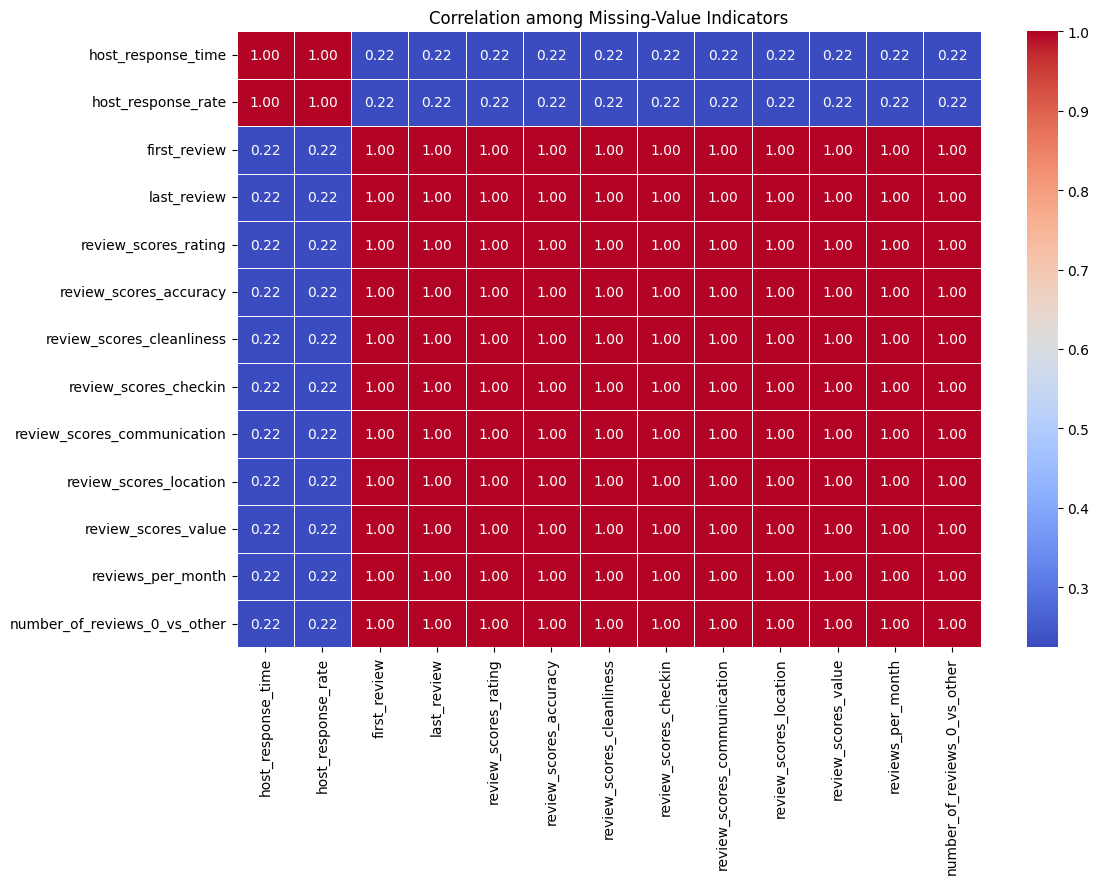

In [18]:
cols_with_missing = [
    "host_response_time", "host_response_rate",
    "first_review", "last_review", "review_scores_rating",
    "review_scores_accuracy", "review_scores_cleanliness",
    "review_scores_checkin", "review_scores_communication",
    "review_scores_location", "review_scores_value",
    "reviews_per_month"
]

corr_matrix = plot_missing_corr_heatmap(
    df=df_raw_columns_dropped,
    missing_columns=cols_with_missing,
    indicator_col="number_of_reviews",
    title="Correlation among Missing-Value Indicators"
)


From the heatmap, it seems that our hypotesis is correct, we now aim to verify whether missing values in review_scores_value are systematically missing across all other review score columns. If confirmed, this would indicate that missing review scores are not random but rather reflect listings that lack reviews.

In [19]:

# Define review score columns
review_columns = [
    "review_scores_value",
    "review_scores_cleanliness",
    "review_scores_location",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_accuracy",
    "review_scores_rating",
    "first_review",
    "last_review",
    "reviews_per_month",
]


In [20]:

df_partial_missing, ids_partial_missing = partial_review_missing(
    df_raw_columns_dropped, review_cols=review_columns
)



Listings with at least one missing review score: 3982
Listings where all review scores are missing: 3978
Listings with some but not all review scores missing: 4


so we know there are 4 that have partial missing but not 0 reviews, although most are totally related. let's see which are.

In [21]:
print(ids_partial_missing)

[2675064, 5296838, 26264851, 857632465549021186]


In [22]:
df_raw_columns_dropped = df_raw_columns_dropped[
    ~df_raw_columns_dropped["id"].isin(ids_partial_missing)
]

In [23]:
df_raw_columns_dropped.shape

(23701, 48)

# Handling Missing Review Scores

After cleaning the outliers (n=4), we need to address the missing values in our `reviews_score` feature. The missingness pattern appears to be **MNAR (Missing Not At Random)**, as these NaN values (≈17% of our dataset) specifically represent listings with no reviews rather than random data loss. This presents an interesting analytical challenge, as conventional imputation methods would be inappropriate given the underlying data-generating process.

## Limitations of Conventional Imputation Approaches

A **complete case analysis** (dropping NaN values) would be statistically unsound given both the substantial proportion of missing data and, more importantly, the informative nature of the missingness itself. The absence of reviews likely correlates with other features in our model (e.g., listing age, pricing strategy, booking frequency) and could provide valuable signal for our price prediction task.

Similarly, traditional imputation methods like **mean/mode substitution** or **random value imputation** would conflate fundamentally different states:
- "No reviews" vs. "Poor reviews"

Such an approach could introduce bias into our model, distorting price elasticity estimations.

## Business and Market Considerations

From a business perspective:
- **New listings** often employ different pricing strategies, frequently offering **introductory discounts** to overcome the "cold start" problem in reputation-based marketplaces.
- This suggests that the relationship between **review scores and pricing isn't purely linear** and might exhibit **time-dependency patterns**.
- From a customer behavior perspective, the decision-making process for booking an unreviewed property differs significantly from selecting among reviewed properties, implying **different price elasticities**.

## Proposed Feature Engineering Approach

To preserve the informative nature of the missing reviews while enabling robust statistical modeling, we propose creating a **categorical feature** based on review score quantiles:

| **Category**       | **Definition** |
|--------------------|---------------|
| `no_reviews`      | Listings with missing review scores (unrated properties) |
| `low_reviews`     | Listings with review scores **below 4.0** (likely negative guest experiences) |
| `medium_reviews`  | Listings with review scores **between 4.0 and 4.6** (average-rated properties) |
| `high_reviews`    | Listings with review scores **between 4.6 and 4.8** (good but not premium) |
| `top_reviews`     | Listings with review scores **above 4.8** (premium properties, likely Superhosts) |

This approach maintains the natural ordering while preserving the distinct character of unreviewed listings. An **ordinal encoding structure** or **dummy encoding** can be used depending on the modeling approach.

## Dual-Track Modeling Strategy

We will implement **two modeling strategies**:

1. **Full dataset with categorical encoding**:
   - Suitable for tree-based models (e.g., XGBoost, which handles categorical features well)
   - Logistic regression with appropriate dummy encoding

2. **Subset with only reviewed listings**:
   - Used for exploring pure numerical relationships
   - Potentially useful for price elasticity analysis and market segmentation

## Considered but Rejected Approaches

- **Host-based imputation** (using review patterns from other properties by the same host)
  - While theoretically sound, this approach introduces complexity in host clustering.
  - Additional preprocessing steps would be required to ensure that it benefits model performance.

## Future Iterations and Enhancements

- Implement a more **sophisticated ordinal encoding** that incorporates **temporal aspects** of review accumulation.
- Investigate **composite features** that combine review status with other **trust signals** (e.g., host verification status, response rate) to better model the **trust premium in pricing**.


In [24]:
review_score_columns = [
    "review_scores_value",
    "review_scores_cleanliness",
    "review_scores_location",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_accuracy",
    "review_scores_rating",
]

In [25]:
df_raw_columns_dropped[review_score_columns].dtypes           # any object dtypes?


review_scores_value            float64
review_scores_cleanliness      float64
review_scores_location         float64
review_scores_checkin          float64
review_scores_communication    float64
review_scores_accuracy         float64
review_scores_rating           float64
dtype: object

imported the function 'categorize_reviews' that takes as input the DataFrame and transforms the numeric variable "revirew_score" into an ordered, categorical scale.

    Categories (worst ➜ best)
    -------------------------
    no_reviews    : NaN / missing
    low_reviews   : score  < 4.0
    medium_reviews: 4.0 ≤ score < 4.6
    high_reviews  : 4.6 ≤ score ≤ 4.8
    top_reviews   : score  > 4.8

used these categories since most of the reviews are above 4.


In [26]:
df_raw_columns_dropped = categorize_reviews(df_raw_columns_dropped, review_score_columns)


In [27]:
df_raw_columns_dropped[review_score_columns].dtypes           # any object dtypes?


review_scores_value            category
review_scores_cleanliness      category
review_scores_location         category
review_scores_checkin          category
review_scores_communication    category
review_scores_accuracy         category
review_scores_rating           category
dtype: object

In [28]:
# Define review score columns
review_date_columns = [
   "first_review",
    "last_review",
    "reviews_per_month"
]


using the function "convert_and_calculate_days" that converts a date column to datetime format, calculates the difference (in days)
from a reference date column, and replaces the original column with the new "days_since_{original_name}" column.


In [29]:
df_raw_columns_dropped = convert_and_calculate_days(df_raw_columns_dropped, 'first_review',  'last_scraped')
df_raw_columns_dropped = convert_and_calculate_days(df_raw_columns_dropped, 'last_review', 'last_scraped') # remove semicolon to see the resulting dataset

In [30]:
df_raw_columns_dropped['days_since_last_review'].describe()

count    19723.000000
mean       217.524210
std        465.806883
min          0.000000
25%         15.000000
50%         59.000000
75%        156.000000
max       4391.000000
Name: days_since_last_review, dtype: float64

In [31]:
df_raw_columns_dropped['days_since_first_review'].describe()

count    19723.000000
mean      1000.822644
std       1053.714301
min          0.000000
25%        219.000000
50%        545.000000
75%       1435.500000
max       5265.000000
Name: days_since_first_review, dtype: float64

In [32]:
df_raw_columns_dropped = create_first_review_age_categories(df_raw_columns_dropped, column_name='days_since_first_review')


Successfully converted 'days_since_first_review' to categorical
Records processed: 23,701 | Missing values handled: 0

Category Distribution:
------------------------------------------------------------
no_review_yet                          3,978   16.8%
very_new (<= 1 month)                    444    1.9%
new (<= 6 months)                      3,729   15.7%
established (<= 1 year)                2,812   11.9%
mature (<= 3 years)                    7,008   29.6%
veteran (<= 5 years)                   1,550    6.5%
legacy (over 5 years)                  4,180   17.6%
------------------------------------------------------------
Total                                 23,701 100.0%


In [33]:
df_raw_columns_dropped = create_last_review_recency_categories(df_raw_columns_dropped, column_name = 'days_since_last_review')

Successfully converted 'days_since_last_review' to categorical
Records processed: 23,701 | Missing values now: 0

Category Distribution:
-------------------------------------------------------
no_review                              3,978   16.8%
very_recent (<= 1 week)                2,959   12.5%
recent (<= 1 month)                    5,000   21.1%
somewhat_recent (<= 3 months)          4,175   17.6%
old (<= 6 months)                      2,934   12.4%
very_old (<= 1 year)                   1,587    6.7%
dormant (over a year)                  3,068   12.9%
-------------------------------------------------------
Total                                 23,701 100.0%


### 'reviews_per_month'
Replace NaN values in 'reviews_per_month' with 0, since we know it means that no review was ever given.with 0, since we know it means that no review was ever given.

In [34]:

df_raw_columns_dropped['reviews_per_month'] = df_raw_columns_dropped['reviews_per_month'].fillna(0)

## 'host_response_rate' and 'host_response_time'

we saw that these two variables have missing values perfectly correlated. This means that if the value is missing in host_response_rate, it is probably missing in host_response_time as well. We can look at 

In [35]:

# Columns of interest
host_rates = [
    'host_response_time',
    'host_acceptance_rate',
    'host_response_rate'
]


In [36]:

# 2. Peek at unique values (to see if they have strings like '%')
for col in host_rates:
    print(f"\nColumn: {col}")
    print("Unique Values:", df_raw_columns_dropped[col].unique())


Column: host_response_time
Unique Values: [nan 'within an hour' 'within a day' 'within a few hours'
 'a few days or more']

Column: host_acceptance_rate
Unique Values: ['0%' '20%' '38%' '75%' '25%' '80%' '100%' '98%' '72%' '27%' '69%' '86%'
 '50%' nan '89%' '32%' '33%' '88%' '99%' '94%' '84%' '63%' '6%' '42%'
 '78%' '90%' '64%' '49%' '56%' '13%' '77%' '68%' '67%' '97%' '83%' '95%'
 '71%' '44%' '87%' '51%' '30%' '96%' '91%' '36%' '58%' '81%' '41%' '59%'
 '70%' '60%' '16%' '82%' '73%' '47%' '92%' '46%' '76%' '74%' '40%' '18%'
 '17%' '65%' '85%' '15%' '79%' '93%' '57%' '43%' '22%' '29%' '14%' '35%'
 '45%' '37%' '8%' '21%' '53%' '9%' '48%' '10%' '24%' '4%' '31%' '54%' '3%'
 '66%' '55%' '62%' '12%' '11%' '61%' '7%' '23%' '19%' '26%' '5%' '39%'
 '34%' '28%' '2%' '52%']

Column: host_response_rate
Unique Values: [nan '100%' '50%' '67%' '90%' '75%' '10%' '93%' '30%' '0%' '70%' '89%'
 '55%' '88%' '20%' '60%' '71%' '14%' '25%' '80%' '96%' '63%' '91%' '94%'
 '99%' '92%' '33%' '98%' '57%' '40%' '

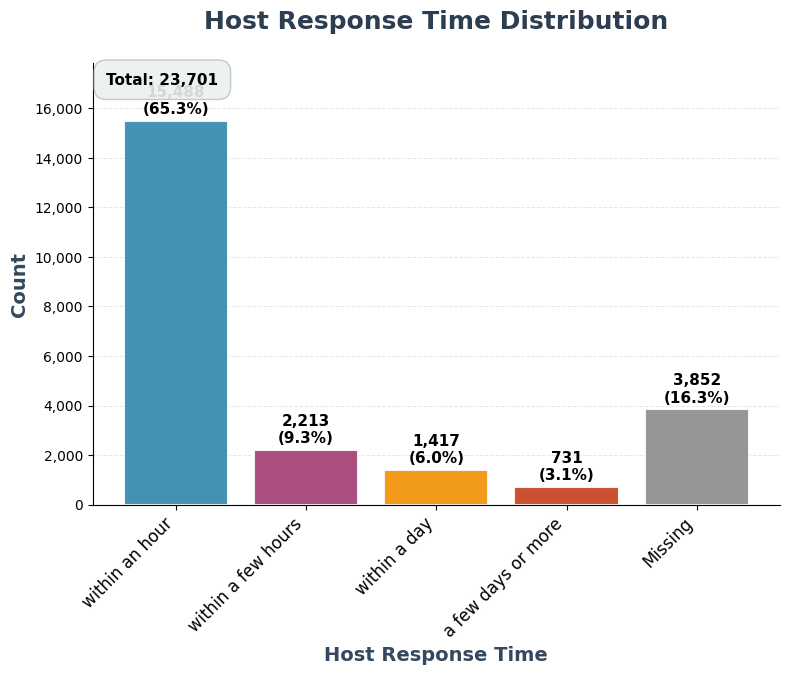


HOST RESPONSE TIME DISTRIBUTION
within an hour        :   15,488 (  65.3%)
within a few hours    :    2,213 (   9.3%)
within a day          :    1,417 (   6.0%)
a few days or more    :      731 (   3.1%)
Missing               :    3,852 (  16.3%)
--------------------------------------------------
TOTAL                 :   23,701 (100.0%)


In [37]:

# Example usage:
plot_categorical_distribution(df_raw_columns_dropped, 'host_response_time', category_order=[
    'within an hour',
    'within a few hours',
    'within a day',
    'a few days or more',
    'Missing'
])

# plot_categorical_distribution(df, 'room_type', title='Room Type Distribution')
# plot_categorical_distribution(df, 'neighbourhood', category_order=['Downtown', 'Suburbs', 'Other'])

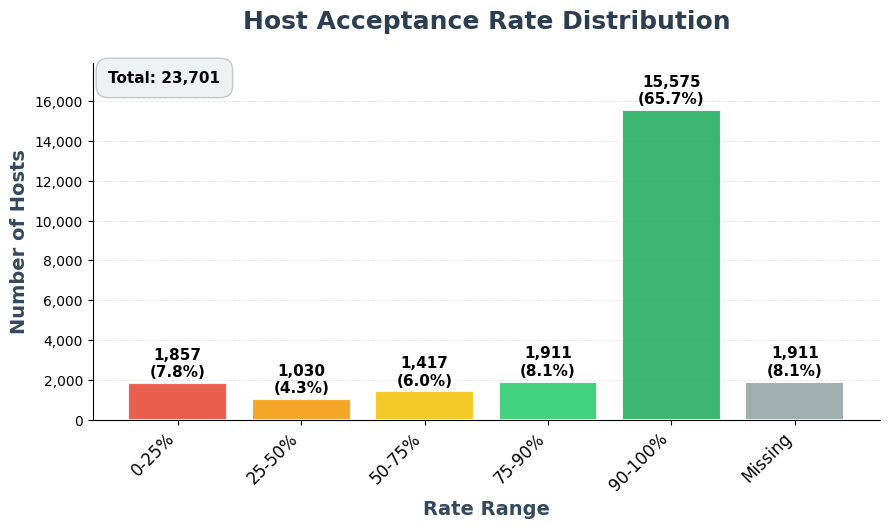


HOST ACCEPTANCE RATE DISTRIBUTION
0-25%          :    1,857 (   7.8%)
25-50%         :    1,030 (   4.3%)
50-75%         :    1,417 (   6.0%)
75-90%         :    1,911 (   8.1%)
90-100%        :   15,575 (  65.7%)
Missing        :    1,911 (   8.1%)
--------------------------------------------------
TOTAL          :   23,701 (100.0%)


In [38]:
plot_percentage_distribution(df_raw_columns_dropped, 'host_acceptance_rate', bins = [0, 25, 50, 75, 90, 100],figsize=(9, 5))

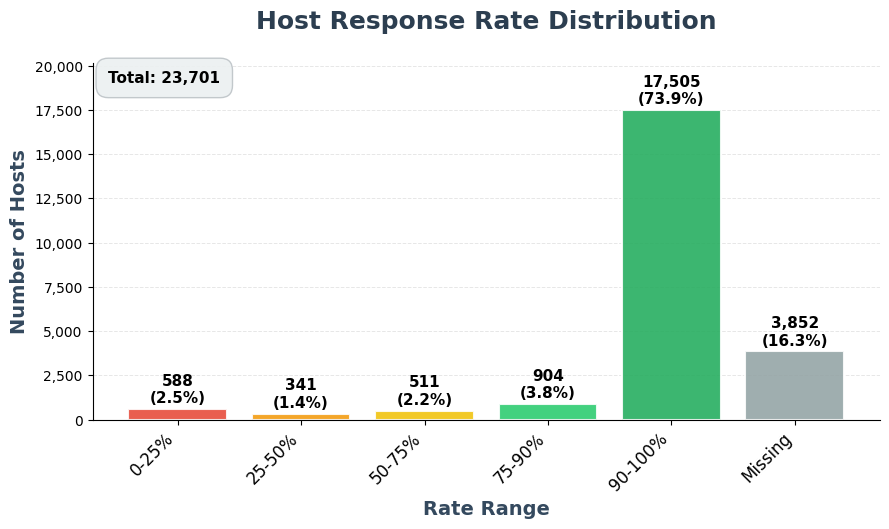


HOST RESPONSE RATE DISTRIBUTION
0-25%          :      588 (   2.5%)
25-50%         :      341 (   1.4%)
50-75%         :      511 (   2.2%)
75-90%         :      904 (   3.8%)
90-100%        :   17,505 (  73.9%)
Missing        :    3,852 (  16.3%)
--------------------------------------------------
TOTAL          :   23,701 (100.0%)


In [39]:
plot_percentage_distribution(df_raw_columns_dropped, 'host_response_rate', bins = [0, 25, 50, 75, 90, 100], figsize=(9, 5))

In [40]:
# Correlation matrix of missing values (to prove the 1.0 correlation)
missing_correlation = df_raw_columns_dropped[['host_response_time', 'host_response_rate', 'host_acceptance_rate']].isnull().corr()

print( missing_correlation)

                      host_response_time  host_response_rate  \
host_response_time              1.000000            1.000000   
host_response_rate              1.000000            1.000000   
host_acceptance_rate            0.568074            0.568074   

                      host_acceptance_rate  
host_response_time                0.568074  
host_response_rate                0.568074  
host_acceptance_rate              1.000000  


In [41]:
# Convert percentage strings to numeric for analysis
def convert_percentage(series):
    return series.str.rstrip('%').astype(float) / 100

# Basic statistics for acceptance and response rates
acceptance_numeric = convert_percentage(df_raw_columns_dropped['host_acceptance_rate'].dropna())
response_numeric = convert_percentage(df_raw_columns_dropped['host_response_rate'].dropna())

print("Host Acceptance Rate Statistics:")
print(acceptance_numeric.describe())
print("\nHost Response Rate Statistics:")
print(response_numeric.describe())

# Count of zero values in response rate
zero_response_count = (df_raw_columns_dropped['host_response_rate'] == '0%').sum()

Host Acceptance Rate Statistics:
count    21790.000000
mean         0.848665
std          0.285724
min          0.000000
25%          0.860000
50%          0.990000
75%          1.000000
max          1.000000
Name: host_acceptance_rate, dtype: float64

Host Response Rate Statistics:
count    19849.000000
mean         0.942075
std          0.180693
min          0.000000
25%          0.990000
50%          1.000000
75%          1.000000
max          1.000000
Name: host_response_rate, dtype: float64


please format this for markdown without changing words "Here's a professional rewrite of your analysis:

---

## Analysis of Host Response Metrics

### Missing Data Patterns
Approximately 16% of entries for both `host_response_time` and `host_response_rate` contain missing values, while `host_acceptance_rate` exhibits a lower missing rate of around 8%. The perfect correlation (1.0) in missingness between `host_response_time` and `host_response_rate` indicates these metrics are recorded simultaneously or not at all, suggesting these hosts may not have received guest inquiries.

### Distribution Characteristics
For `host_acceptance_rate` and `host_response_rate`, the median values approach 1.0 after converting from percentage strings to numeric format, indicating exceptionally high responsiveness and acceptance rates when data is available. Specifically:

- The 25th percentile (Q1) of `host_response_rate` is 0.99, meaning 75% of hosts maintain response rates of 99% or higher
- The median is 1.00, indicating more than half of all hosts achieve near-perfect response rates
- This distribution clustering suggests most active hosts demonstrate high responsiveness, with only a small fraction exhibiting notably lower rates

### Feature Engineering Implications
Given the limited variability in these metrics, their utility as continuous variables for predictive modeling may be constrained. The high concentration of values near 1.0 could introduce noise rather than meaningful signal. Therefore, I will:

1. **Temporary exclusion** of these variables from initial modeling phases
2. **Categorical transformation** if later inclusion is desired (e.g., "Unknown", "Below Average", "High Performance")
3. **Further distributional analysis** to identify optimal binning thresholds before implementation

### Host Activity Segmentation Hypothesis
The systematic absence of response metrics likely indicates hosts who have not engaged in booking transactions. This pattern supports segmentation into distinct host categories:

- **Active Hosts**: Complete response metrics with established booking history
- **Emerging Hosts**: Some booking activity but incomplete metric development  
- **Inactive/New Hosts**: No response metrics, potentially indicating zero inquiries or recent market entry




In [42]:
df_raw_columns_dropped.drop(columns = host_rates, inplace = True)

# Features with Low Missing Values (<15%)

In [43]:
missing_values = df_raw_columns_dropped.isnull().sum().sort_values(ascending=False)  
missing_percentage = (missing_values / len(df_raw_columns_dropped)) * 100 
missing_df = pd.DataFrame({"Missing Values": missing_values, "Percentage": missing_percentage})
missing_df[missing_df["Missing Values"] > 0]

,Missing Values,Percentage
beds,1730,7.299270
bathrooms,1684,7.105185
price,1677,7.075651
host_is_superhost,831,3.506181
bedrooms,324,1.367031


I re use the function plot_percentage_distribution saved in _04_represent_numerical_data.py

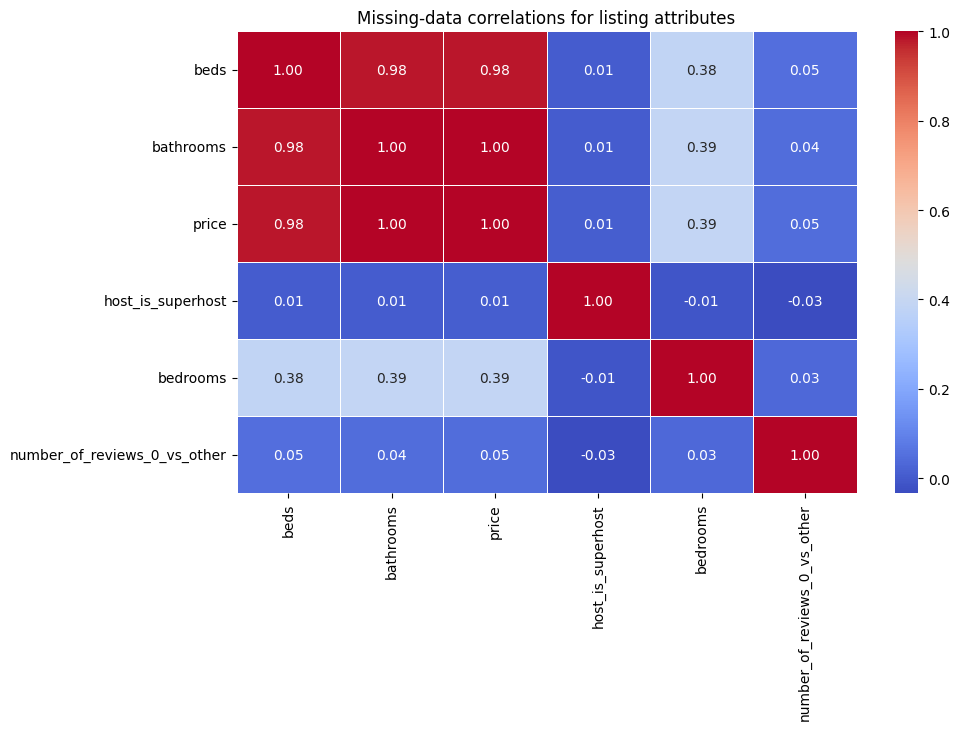

In [44]:
subset_cols = ["beds", "bathrooms", "price", "host_is_superhost", "bedrooms"]

corr = plot_missing_corr_heatmap(
    df_raw_columns_dropped,
    subset_cols,
    indicator_col="number_of_reviews",
    figsize=(10, 6),
    title="Missing-data correlations for listing attributes"
)



From the heatmap, we notice that `price` is often missing when both `bedrooms` and `bathrooms` are also missing. It may be interesting to further investigate when exactly `price` is missing. For example, whether this happens more frequently for certain types of listings (e.g., entire apartments or private rooms).  

However, since our goal is to **predict the price**, I believe it does not make sense to impute `price`, `bedrooms`, or `bathrooms`, which also appear to be highly correlated.  

Given the importance of `price` as our target variable, we will simply **remove the rows where `price` is missing**.


In [45]:
df_raw_columns_dropped = df_raw_columns_dropped[df_raw_columns_dropped["price"].notna()]
df_raw_columns_dropped = df_raw_columns_dropped[df_raw_columns_dropped["beds"].notna()]

In [46]:
missing_values = df_raw_columns_dropped.isnull().sum().sort_values(ascending=False)  
missing_percentage = (missing_values / len(df_raw_columns_dropped)) * 100 
missing_df = pd.DataFrame({"Missing Values": missing_values, "Percentage": missing_percentage})
missing_df[missing_df["Missing Values"] > 0]

,Missing Values,Percentage
host_is_superhost,764,3.477311
bedrooms,26,0.118338
bathrooms,7,0.031860


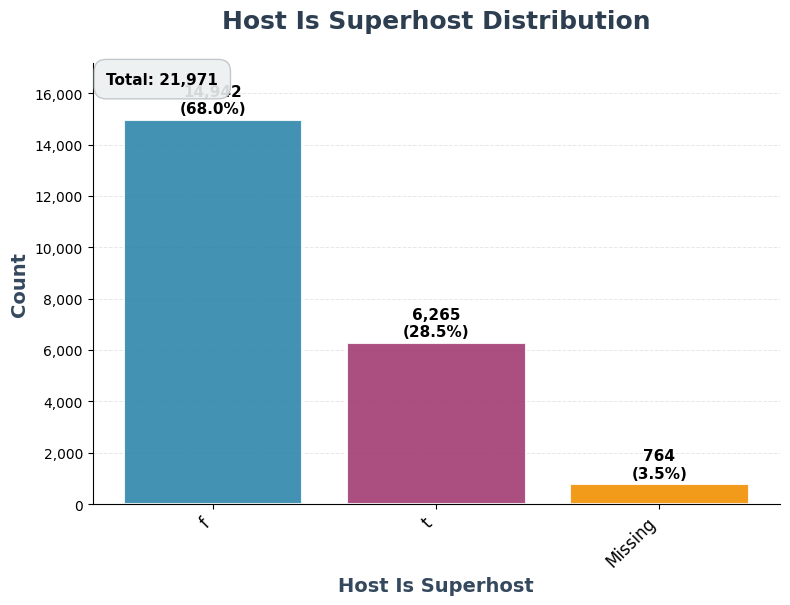


HOST IS SUPERHOST DISTRIBUTION
f                     :   14,942 (  68.0%)
t                     :    6,265 (  28.5%)
Missing               :      764 (   3.5%)
--------------------------------------------------
TOTAL                 :   21,971 (100.0%)


In [47]:
plot_categorical_distribution(df_raw_columns_dropped, 'host_is_superhost')

## Host is superhost

In [48]:
# Impute missing values in 'host_is_superhost' with the most frequent value
most_frequent_value = df_raw_columns_dropped['host_is_superhost'].mode()[0]
df_raw_columns_dropped['host_is_superhost'] = df_raw_columns_dropped['host_is_superhost'].fillna(most_frequent_value)

In [49]:
import pandas as pd

cols_num = ['beds', 'bedrooms', 'bathrooms']

# Build a table: index = property_type, columns = numeric field, values = # missing
summary = (
    pd.concat(
        {
            col: df_raw_columns_dropped.loc[df_raw_columns_dropped[col].isna(), 'property_type']
                  .value_counts()
            for col in cols_num
        },
        axis=1
    )
    .fillna(0)
    .astype(int)
    .sort_index()
)

# Add row-wise percentages for readability
percent = summary.div(summary.sum(), axis=1).mul(100).round(1)
summary_with_pct = summary.astype(str) + " (" + percent.astype(str) + "%)"

display(summary_with_pct)          # Jupyter-friendly

,beds,bedrooms,bathrooms
property_type,,,
Entire rental unit,0 (nan%),9 (34.6%),1 (14.3%)
Private room in rental unit,0 (nan%),1 (3.8%),2 (28.6%)
Room in hotel,0 (nan%),1 (3.8%),4 (57.1%)
Shared room in bed and breakfast,0 (nan%),3 (11.5%),0 (0.0%)
Shared room in rental unit,0 (nan%),12 (46.2%),0 (0.0%)


## Beds

In [50]:
correlation = df_raw_columns_dropped[['accommodates', 'beds']].corr().loc['accommodates', 'beds']
print(f"Pearson correlation between accommodates and beds: {correlation:.2f}")

Pearson correlation between accommodates and beds: 0.69


In [51]:
df_raw_columns_dropped['accommodates'].describe()

count    21971.000000
mean         3.243366
std          1.508250
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         16.000000
Name: accommodates, dtype: float64

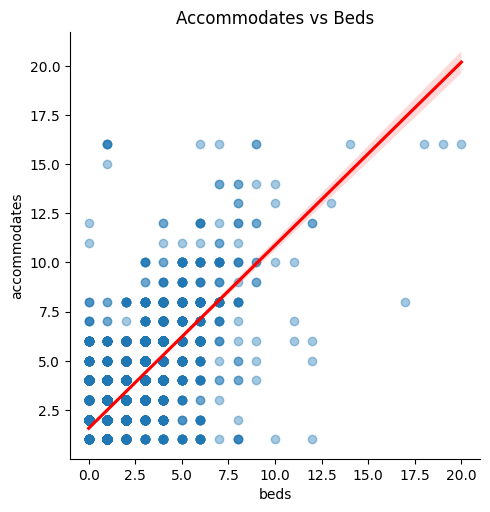

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(data=df_raw_columns_dropped, x='beds', y='accommodates', 
           scatter_kws={'alpha': 0.4}, line_kws={'color': 'red'})
plt.title("Accommodates vs Beds")
plt.show()

I will assume that it is realistic that the number of beds will be the same of the number of accomodates (person that can be hosted in the house)

In [53]:
# Fill missing beds with accommodates (assumes 1 person per bed)
df_raw_columns_dropped['beds'] = df_raw_columns_dropped['beds'].fillna(
    df_raw_columns_dropped['accommodates'].round()
)

## Bedrooms and Bathrooms

In [54]:
missing_values = df_raw_columns_dropped.isnull().sum().sort_values(ascending=False)  
missing_percentage = (missing_values / len(df_raw_columns_dropped)) * 100 
missing_df = pd.DataFrame({"Missing Values": missing_values, "Percentage": missing_percentage})
missing_df[missing_df["Missing Values"] > 0]

,Missing Values,Percentage
bedrooms,26,0.118338
bathrooms,7,0.031860


In [55]:
# Define mappings
bedroom_map = {
    'Shared room in rental unit': 0,
    'Shared room in hostel': 0,
    'Shared room in bed and breakfast': 0,
    'Private room in rental unit': 1,
    'Room in hotel': 1
}

bathroom_map = {
    'Room in hotel': 1,
    'Private room in rental unit': 1
}

# Apply conditional imputation
for col, mapping in [('bedrooms', bedroom_map), ('bathrooms', bathroom_map)]:
    mask = df_raw_columns_dropped[col].isna()
    df_raw_columns_dropped.loc[mask, col] = (
        df_raw_columns_dropped.loc[mask, 'property_type'].map(mapping)
    )

In [56]:
df_raw_columns_dropped[['bedrooms', 'bathrooms']].isna().sum()

bedrooms     9
bathrooms    1
dtype: int64

In [57]:
df_raw_columns_dropped = df_raw_columns_dropped[df_raw_columns_dropped["bedrooms"].notna()]
df_raw_columns_dropped = df_raw_columns_dropped[df_raw_columns_dropped["bathrooms"].notna()]

we correctly removed all missing values

In [58]:
missing_values = df_raw_columns_dropped.isnull().sum().sort_values(ascending=False)  
missing_percentage = (missing_values / len(df_raw_columns_dropped)) * 100 
missing_df = pd.DataFrame({"Missing Values": missing_values, "Percentage": missing_percentage})
missing_df[missing_df["Missing Values"] > 0]

,Missing Values,Percentage


### dropping listing_url since it is not necessary

In [59]:
df_raw_columns_dropped = df_raw_columns_dropped.drop(columns="listing_url")

Latitude and longitude will be saved in a dataframe for later use

In [60]:
lat_long = df_raw_columns_dropped[['latitude', 'longitude']]

In [61]:
df_raw_columns_dropped = df_raw_columns_dropped.drop(columns=["latitude", "longitude"])

Checking whether boolean and categorical features contain sufficient numbers of instances in each category to make them worth including:

In [62]:
# Count of unique values
print(df_raw_columns_dropped['host_has_profile_pic'].value_counts(dropna=False))

# Percentage distribution
print(df_raw_columns_dropped['host_has_profile_pic'].value_counts(normalize=True, dropna=False) * 100)


host_has_profile_pic
t    21262
f      699
Name: count, dtype: int64
host_has_profile_pic
t    96.817085
f     3.182915
Name: proportion, dtype: float64


In [63]:
df_raw_columns_dropped = df_raw_columns_dropped.drop(columns='host_has_profile_pic')

In [64]:
df_raw_columns_dropped = df_raw_columns_dropped.drop(columns='host_id')

# Feature engineering

## Host Since into dates

 
### CONVERT 'host_since' to DATETIME & CREATE 'host_since_days' 
(first and last review done in the previous notebook)
    

- **Current Data Type:** `object`
- **Observations:** Represents the date when the host started.
- **Actions:**
  - Convert to a datetime format.
  - Calculate the difference in days between `last_scraped` and `host_since` to create a new feature (e.g., `days_since_host`).
  - remove `host_since` which is not needed anymore

In [65]:
df_raw_columns_dropped = convert_and_calculate_days(df_raw_columns_dropped, 'host_since',  'last_scraped')

## Transform objects into categories ordered categories:
***`room_type`***

- **Current Data Type:** `object`
- **Observations:** Already categorized (e.g., 'Shared room' < 'Private room' < 'Hotel room' < 'Entire home/apt')
- **Actions:**
  - from dtype "object"to categorical variable. (organized)

In [66]:
room_type_order = ["Shared room", "Private room", "Hotel room", "Entire home/apt"]
df_raw_columns_dropped = convert_to_ordered_category(df_raw_columns_dropped, 'room_type', room_type_order)

In [67]:
print(df_raw_columns_dropped['room_type'].dtype)
print(df_raw_columns_dropped['room_type'].unique())

category
['Private room', 'Entire home/apt', 'Shared room', 'Hotel room']
Categories (4, object): ['Shared room' < 'Private room' < 'Hotel room' < 'Entire home/apt']


## Binary Variable Transformation: Boolean vs. Categorical

Boolean (`True/False`) is the most efficient representation for binary data in **pandas**, **NumPy**, and **scikit-learn**:
- Uses **less memory** than categorical types, making operations faster.
- Works seamlessly with **logical operations** (`df[df['column']]` to filter `True` values).
- Directly compatible with **machine learning models** in `scikit-learn`, which automatically interpret `bool` as `0/1` without additional encoding.

Categorical (`'Yes'/'No'`) would be better for **reports, visualizations, and human-readable summaries**, mapping binary values to **'Yes'/'No'** can improve clarity. Some plotting libraries like **Matplotlib** and **Seaborn** handle categorical data better when creating labeled bar charts or grouped statistics.

i guess we'll just use yes/no as titles in plots.

In [68]:

# List of binary columns
binary_columns = [
    'host_about_present', 
    'neighborhood_overview_present'
]

# Apply the function
df_raw_columns_dropped = convert_columns_to_boolean(df_raw_columns_dropped, binary_columns)

# Check transformation
df_raw_columns_dropped[binary_columns].info()


<class 'pandas.core.frame.DataFrame'>
Index: 21961 entries, 0 to 23704
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   host_about_present             21961 non-null  bool 
 1   neighborhood_overview_present  21961 non-null  bool 
dtypes: bool(2)
memory usage: 214.5 KB


In [69]:
# List of columns to transform
boolean_columns = ['host_is_superhost', 'host_identity_verified']

# Apply transformation
df_raw_columns_dropped= convert_columns_to_boolean(df_raw_columns_dropped, boolean_columns)



## **host_location**
- **Current Data Type:** `object`
- **Observations:** Contains various host locations, with Milan being the predominant value.
- **Actions:**
  - Consider reclassification based on distance.
  - Alternatively, group values into key categories (e.g., major Italian cities such as Milan, Turin, Rome, etc. vs. foreign locations grouped by country).

In [70]:
# Get all unique host locations sorted by frequency
unique_host_locations = df_raw_columns_dropped['host_location'].value_counts()

# Display the full list of unique host locations
print("\n---UNIQUE HOST LOCATIONS SORTED BY FREQUENCY---")
print(unique_host_locations)
print(f"\nTotal unique host locations: {df_raw_columns_dropped['host_location'].nunique()}")





---UNIQUE HOST LOCATIONS SORTED BY FREQUENCY---
host_location
Milan, Italy             19717
Rome, Italy                181
Italy                      116
Milano, Italy              101
Lombardy, Italy             89
                         ...  
Akumal, Mexico               1
Jesi, Italy                  1
Solbiate Olona, Italy        1
Arosio, Italy                1
Agnadello, Italy             1
Name: count, Length: 552, dtype: int64

Total unique host locations: 552


we need to reduce the amount of unique classes

In [71]:
df_raw_columns_dropped["host_location"] = df_raw_columns_dropped["host_location"].map(host_location_dict)

In [72]:
print(df_raw_columns_dropped[['host_location', 'host_location']].head(5))


  host_location host_location
0         Milan         Milan
1         Milan         Milan
2         Milan         Milan
3         Milan         Milan
4         Milan         Milan


In [73]:
# Get all unique host locations sorted by frequency
unique_host_locations = df_raw_columns_dropped['host_location'].value_counts()

# Display the full list of unique host locations
print("\n--- FULL LIST OF UNIQUE HOST LOCATIONS ---")
print(unique_host_locations)
print(f"\nTotal unique host locations: {df_raw_columns_dropped['host_location'].nunique()}")




--- FULL LIST OF UNIQUE HOST LOCATIONS ---
host_location
Milan                    19818
Lombardy                   644
Lazio                      194
Tuscany                    133
Piedmont                   124
Unknown_Italy              116
Emilia-Romagna              79
United States               79
United Kingdom              76
Campania                    65
Switzerland                 63
Veneto                      61
Liguria                     54
Apulia                      47
Sicily                      41
Spain                       41
Mexico                      27
France                      27
Friuli-Venezia Giulia       21
Germany                     20
Sardinia                    19
Calabria                    17
Marche                      16
United Arab Emirates        16
Trentino-Alto Adige         11
Netherlands                 10
Abruzzo                     10
Umbria                       8
Australia                    8
Brazil                       7
Portugal    

way too many 

In [74]:
df_raw_columns_dropped["host_location"] = df_raw_columns_dropped["host_location"].map(LOCATION_HIERARCHY)

In [75]:
# Get all unique host locations sorted by frequency
unique_host_locations = df_raw_columns_dropped['host_location'].value_counts()

# Display the full list of unique host locations
print("\n--- FULL LIST OF UNIQUE HOST LOCATIONS ---")
print(unique_host_locations)
print(f"\nTotal unique host locations: {df_raw_columns_dropped['host_location'].nunique()}")




--- FULL LIST OF UNIQUE HOST LOCATIONS ---
host_location
Milan                     19818
Central/Southern Italy      668
Lombardy                    644
Northern Italy              354
Extra-EU                    241
Europe                      219
Name: count, dtype: int64

Total unique host locations: 6


In [76]:
df_raw_columns_dropped["host_location"]

0        Milan
1        Milan
2        Milan
3        Milan
4        Milan
         ...  
23698    Milan
23699    Milan
23700    Milan
23703    Milan
23704    Milan
Name: host_location, Length: 21961, dtype: object

In [77]:
# Check for missing values in the 'host_location' column
missing_values = df_raw_columns_dropped['host_location'].isna().sum()
print(f"Number of missing values in 'host_location': {missing_values}")

Number of missing values in 'host_location': 17


In [78]:
# Calculate the mode of the column (most frequent value)
mode_value = df_raw_columns_dropped['host_location'].mode()[0]

# Fill missing values with the mode
df_raw_columns_dropped['host_location'].fillna(mode_value, inplace=True)

## **property_type**
- **Current Data Type:** `object`
- **Observations:** Contains many unique values (e.g., “Entire rental unit”, “Private room in condo”, “Boat”, etc.).
- **Actions:**

  - Some cleaning of property types is required as there are a large number of categories with only a few listings.

In [79]:
#-------------------------------------------------------------
# 2) PROPERTY_TYPE: Unique values and frequencies
# -------------------------------------------------------------
print("\n--- PROPERTY TYPE ANALYSIS ---")

unique_property_types = df_raw_columns_dropped['property_type'].value_counts()
# Display the full list of unique host locations
print("\n--- FULL LIST OF UNIQUE HOST LOCATIONS ---")
print(unique_property_types)
print(f"\nTotal unique host locations: {df_raw_columns_dropped['property_type'].nunique()}")





--- PROPERTY TYPE ANALYSIS ---

--- FULL LIST OF UNIQUE HOST LOCATIONS ---
property_type
Entire rental unit                    13143
Entire condo                           4496
Private room in rental unit            1499
Private room in condo                   653
Entire loft                             551
Entire home                             370
Entire serviced apartment               235
Entire vacation home                    177
Private room in bed and breakfast       153
Private room in home                    116
Shared room in rental unit               99
Private room in loft                     50
Room in hotel                            50
Room in boutique hotel                   36
Shared room in hostel                    30
Tiny home                                23
Private room in vacation home            21
Private room in villa                    20
Private room in hostel                   20
Private room in guesthouse               19
Entire guest suite            

In [80]:
df_raw_columns_dropped["property_type"] = df_raw_columns_dropped["property_type"].map(property_type_dict)

In [81]:
# Which property_types weren't found in the dictionary?
unmapped = df_raw_columns_dropped[df_raw_columns_dropped["property_type"].isna()]["property_type"].unique()
print("Unmapped property types:", unmapped)

Unmapped property types: []


## **ACCOMMODATES**

In [82]:
# -------------------------------------------------------------
# 3) ACCOMMODATES: Distribution analysis
# -------------------------------------------------------------
print("\n--- ACCOMMODATES ANALYSIS ---")
print(df_raw_columns_dropped['accommodates'].describe())  # Summary statistics




--- ACCOMMODATES ANALYSIS ---
count    21961.000000
mean         3.243750
std          1.508298
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         16.000000
Name: accommodates, dtype: float64


## **AMENITIES**

Amenities is a list of additional features in the property, e.g. whether it has a TV or parking. Examples are below:

In [83]:
# Example of amenities listed
df_raw_columns_dropped.amenities[:1].values

array(['["First aid kit", "Hangers", "Wifi", "Elevator", "Gym", "Host greets you", "Kitchen", "Paid parking on premises", "Essentials", "Iron", "Air conditioning", "Heating", "Shampoo", "Breakfast", "Washer", "TV"]'],
      dtype=object)

In [84]:
import re
amenities_list = list(df_raw_columns_dropped.amenities)
amenities_list_string = " ".join(amenities_list)
# Remove all brackets and quotes
amenities_list_string = re.sub(r'[{}"]', '', amenities_list_string)
# Split by comma and clean
amenities_set = [x.strip() for x in amenities_list_string.split(',') if x.strip()]
amenities_set = set(amenities_set)

In [85]:
amenities_set

{'Paid parking garage on premises \\u2013 25 spaces',
 'Wifi \\u2013 43 Mbps',
 'Dac body soap',
 '48 inch HDTV with standard cable',
 'HDTV with Apple TV',
 'Gaggenau oven',
 'Candy  induction stove',
 '40 inch HDTV with Apple TV',
 'Golf course view',
 'Fast wifi \\u2013 245 Mbps',
 'Fast wifi \\u2013 531 Mbps',
 'TV] [Essentials',
 'Hotpoint induction stove',
 'Different body soap',
 'treadmill',
 'Elica Nikola Tesla cappa integrata induction stove',
 'Privato shampoo',
 'Clamp on table seat high chair',
 'Sharp refrigerator',
 '36 inch HDTV',
 'Acqua di Parma shampoo',
 'Fast wifi \\u2013 56 Mbps',
 'Ortega conditioner',
 'PARCO1923 body soap',
 'Fast wifi \\u2013 414 Mbps',
 'Prodotto alberghiero induction stove',
 'Yves Roche body soap',
 '2 BOOST stainless steel induction stove',
 'PERLIER body soap',
 'Fast wifi \\u2013 86 Mbps',
 'EV charger',
 'Wifi \\u2013 35 Mbps',
 'Skate ramp',
 '42 inch HDTV with Chromecast',
 'Fast wifi \\u2013 563 Mbps',
 'General Electric Americano Du

In the list above, some amenities are more important than others (e.g. fast wifi is more likely to increase price than generic body soap brands), and some are likely to be fairly uncommon (e.g. '90 inch HDTV with Apple TV'). Based on research into which amenities are considered by guests to be more important in the Milan market context, a selection of the more important amenities will be extracted. These will be further investigated in the EDA section. For example, if it turns out that almost all properties have/do not have a particular amenity, that feature will not be very useful in helping explain differences in prices.

Milan's unique characteristics as Italy's economic capital, with its dense urban environment, historic architecture, severe parking constraints, and significant business traveler segment, necessitate a context-specific approach to amenity valuation. The city's tourism profile differs markedly from leisure-focused destinations, with approximately 60% of visitors arriving for business purposes, influencing amenity preferences and willingness to pay premiums.

The amenities chosen are (slashes indicate separate categories that can be combined):

- **Air conditioning/central air conditioning/portable air conditioning** - Critical for Milan's increasingly warm summers and expected by international business travelers
- **Elevator** - Premium feature given Milan's prevalence of historic multi-story buildings without lifts
- **Fast wifi (100+ Mbps)/wifi/ethernet connection** - Essential infrastructure for Milan's business-oriented guest profile
- **Paid parking on premises/paid parking garage/free parking** - Exceptionally valuable due to Milan's ZTL restrictions and severe urban parking scarcity
- **Coffee maker/espresso machine/Nespresso** - Cultural imperative in Italian market; significantly impacts guest satisfaction ratings
- **Free washer in unit/paid washer** - High-utility amenity given limited laundromat availability in central Milan
- **Self check-in/lockbox/host greets you** - Operational flexibility crucial for business travelers with varied arrival schedules
- **HDTV with streaming/Netflix/Amazon Prime Video/Apple TV/Chromecast** - Standard entertainment infrastructure expectation
- **Dedicated workspace** - Post-pandemic essential for hybrid work arrangements and extended business stays
- **Private entrance** - Privacy premium in high-density urban environment
- **Refrigerator/oven/microwave/induction stove** - Core kitchen functionality for self-catering preferences
- **Heating/radiant heating** - Seasonal necessity for Milan's continental climate
- **Hot water** - Basic operational requirement
- **First aid kit/fire extinguisher** - Regulatory compliance and risk mitigation features
- **Clothing storage/closet/wardrobe** - Functional necessity for business attire and extended stays
- **Balcony/patio/terrace** - Space premium in constrained urban real estate market
- **Canal view/park view/courtyard view** - Location-specific value differentiators
- **Dishwasher** - Convenience feature for longer-duration bookings

In [86]:
# Define amenity mappings
amenity_mapping = {
    'air_conditioning': 'Air conditioning|Central air conditioning|Portable air conditioning',
    'elevator': 'Elevator',
    'fast_wifi': 'Fast wifi|Ethernet connection',
    'parking': 'parking',
    'coffee_machine': 'Coffee maker|Espresso machine|Nespresso',
    'washer': 'Free washer|Paid washer|Washer',
    'self_check_in': 'Self check-in|Lockbox',
    'streaming_tv': 'Netflix|Amazon Prime Video|Disney+|Apple TV|Chromecast|HDTV',
    'dedicated_workspace': 'Dedicated workspace',
    'private_entrance': 'Private entrance',
    'kitchen_appliances': 'Refrigerator|oven|stove|Microwave',
    'heating': 'Heating|Radiant heating',
    'hot_water': 'Hot water',
    'safety_equipment': 'First aid kit|Fire extinguisher',
    'clothing_storage': 'Clothing storage|closet|wardrobe',
    'balcony': 'Balcony|Patio|Terrace',
    'premium_views': 'Canal view|Park view|Courtyard view',
    'dishwasher': 'Dishwasher',
    'gym': 'Private gym|Shared gym|Exercise equipment|Gym'
}

# Create all columns at once
for amenity, pattern in amenity_mapping.items():
    df_raw_columns_dropped[amenity] = df_raw_columns_dropped['amenities'].str.contains(pattern, na=False).astype(int)

In [87]:
# See all column names to verify new amenity columns exist
print("New columns created:")
amenity_cols = ['air_conditioning', 'elevator', 'fast_wifi', 'parking', 'coffee_machine', 
                'washer', 'self_check_in', 'streaming_tv', 'dedicated_workspace', 
                'private_entrance', 'kitchen_appliances', 'heating', 'hot_water', 
                'safety_equipment', 'clothing_storage', 'balcony', 'premium_views', 
                'dishwasher', 'gym']

print(df_raw_columns_dropped[amenity_cols].columns.tolist())

New columns created:
['air_conditioning', 'elevator', 'fast_wifi', 'parking', 'coffee_machine', 'washer', 'self_check_in', 'streaming_tv', 'dedicated_workspace', 'private_entrance', 'kitchen_appliances', 'heating', 'hot_water', 'safety_equipment', 'clothing_storage', 'balcony', 'premium_views', 'dishwasher', 'gym']


In [88]:
# Count how many properties have each amenity
print("Amenity counts:")
amenity_summary = df_raw_columns_dropped[amenity_cols].sum().sort_values(ascending=False)
print(amenity_summary)

# As percentages
print("\nAmenity percentages:")
amenity_percentages = (df_raw_columns_dropped[amenity_cols].mean() * 100).round(2).sort_values(ascending=False)
print(amenity_percentages)

Amenity counts:
hot_water              18163
washer                 17974
kitchen_appliances     17688
air_conditioning       14848
coffee_machine         13845
heating                13475
clothing_storage       11849
dedicated_workspace    11186
parking                11141
elevator               10682
dishwasher             10145
safety_equipment        9329
self_check_in           8729
private_entrance        4423
streaming_tv            4247
fast_wifi               3300
premium_views           2868
balcony                 2008
gym                      860
dtype: int64

Amenity percentages:
hot_water              82.71
washer                 81.85
kitchen_appliances     80.54
air_conditioning       67.61
coffee_machine         63.04
heating                61.36
clothing_storage       53.95
dedicated_workspace    50.94
parking                50.73
elevator               48.64
dishwasher             46.20
safety_equipment       42.48
self_check_in          39.75
private_entrance     

One way to reduce the number of features (to avoid the curse of dimensionality) is to remove the amenities which add relatively little information, or are relatively unhelpful in differentiating between different listings. Amenity features where either the true or the false category contains fewer than 10% of listings will be removed.

In [89]:
# Replace missing values (NaN) with 0 for all columns listed in 'amenity_cols'.
# This assumes the amenity columns are binary: 1 means the amenity is present, 0 means absent.
# By filling NaNs with 0, we treat missing info as "amenity not available".
df_raw_columns_dropped[amenity_cols] = df_raw_columns_dropped[amenity_cols].fillna(0)

In [90]:
# Create a list of amenity columns that are infrequent:
# i.e., present (sum of 1s) in less than 10% of listings.

# Manually preserve high-value amenities
manual_keep = ['balcony', 'gym']
infrequent_amenities = [
    col for col in amenity_cols 
    if df_raw_columns_dropped[col].sum() < len(df_raw_columns_dropped)/10 
    and col not in manual_keep
]


# Drop those infrequent amenity columns from the DataFrame.
# axis=1 specifies we are dropping columns (not rows).
df_raw_columns_dropped = df_raw_columns_dropped.drop(infrequent_amenities, axis=1)

In [91]:
# Update amenity_cols to only include those still in the DataFrame
amenity_cols = [col for col in amenity_cols if col in df_raw_columns_dropped.columns]

In [92]:
df_raw_columns_dropped[amenity_cols].sum().sort_values(ascending=False)


hot_water              18163
washer                 17974
kitchen_appliances     17688
air_conditioning       14848
coffee_machine         13845
heating                13475
clothing_storage       11849
dedicated_workspace    11186
parking                11141
elevator               10682
dishwasher             10145
safety_equipment        9329
self_check_in           8729
private_entrance        4423
streaming_tv            4247
fast_wifi               3300
premium_views           2868
balcony                 2008
gym                      860
dtype: int64

<Axes: title={'center': 'Amenity Coverage Across Listings (%)'}>

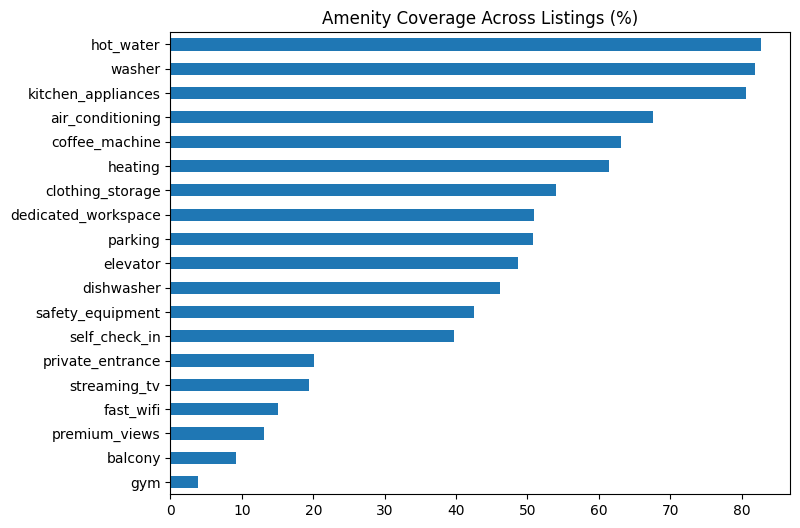

In [93]:
(df_raw_columns_dropped[amenity_cols].mean() * 100).sort_values().plot(
    kind='barh', figsize=(8, 6), title='Amenity Coverage Across Listings (%)'
)

In [94]:
df_raw_columns_dropped = df_raw_columns_dropped.drop(columns=['amenities'])

### PRICE

In [95]:
df_raw_columns_dropped['price'].dtype
df_raw_columns_dropped['price'].head()

0    $100.00
1    $180.00
2     $80.00
3    $110.00
4    $180.00
Name: price, dtype: object

Price will be converted to an integer - currently it is a string because there is a currency sign.

In [96]:
df_raw_columns_dropped['price'] = (
    df_raw_columns_dropped['price']
    .replace('[\$,€]', '', regex=True)  # remove $ or €
    .replace(',', '', regex=True)       # remove commas
    .astype(float)                      # convert to float
)

### AVAILABILITY MEASURES

Availability measures will be for now excluded from the price prediction model. This is because availability and price are highly correlated and likely endogenous - they occur together in determining market outcomes. Lower prices probably lead to higher demand and thus lower availability, while higher prices lead to lower demand and higher availability. Since the causal relationship between availability and price runs in both directions simultaneously, including availability creates interpretation issues and may not provide meaningful predictive insight beyond what property fundamentals already capture.

In [97]:
df_raw_columns_dropped = df_raw_columns_dropped.drop(columns = ['availability_30', 'availability_60', 'availability_90', 'availability_365'])

In [98]:

# Merge the latitude and longitude coordinates back into your main dataset using the index
df_raw_columns_dropped = df_raw_columns_dropped.merge(
    lat_long, 
    left_index=True, 
    right_index=True, 
    how='left'
)



In [99]:

interim_path =  project_root / "data" / "interim"
df_raw_columns_dropped.to_parquet(interim_path / 'data_preprocessed.parquet')